# Garbage Image Classifier

By Alexia Rangel Krashenitsa <br>
Using these references:

*   https://youtu.be/jztwpsIzEGc?si=q6WQdeSIJ3_AtLl4
*   https://www.tensorflow.org/tutorials/images/classification#visualize_the_data
*   https://www.tensorflow.org/tutorials/images/data_augmentation#resizing_and_rescaling




---

## Dependencies and Setup

In [1]:
#Mounting the google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import tensorflow as tf #Tensorflow is a machine learning dataset used for building Neural Nets
import os #Used to navigate through file structures

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth (So tf doesn't use all the memory)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    #limit the memory growth for each gpu
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
#all the available gpus
tf.config.list_physical_devices('GPU')

[]

## Filter images

In [ ]:
import cv2
import imghdr

In [6]:
%cd '/content/drive/MyDrive/Colab Notebooks/data_folder'
%ldir

/content/drive/MyDrive/Colab Notebooks/data_folder
drwx------ 2 root   4096 Apr 27  2023 angry/
drwx------ 2 root   4096 Oct 13 22:07 butterfly-dataset/
drwx------ 2 root   4096 Apr 27  2023 fear/
drwx------ 2 root   4096 Nov  6 19:20 garbage_classification/
drwx------ 2 root   4096 Apr 27  2023 happy/
drwx------ 2 root   4096 Oct 24 04:25 models/
drwx------ 2 root   4096 Apr 27  2023 sad/


In [ ]:
data_dir = 'garbage_classification'

In [ ]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [ ]:
for image_class in os.listdir(data_dir):
#For each folder in the garbage_classification directory,
    for image in os.listdir(os.path.join(data_dir, image_class)):
    #go through each image and check the file path and remove if the image doesn't fit the bill
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

## Load Data

In [ ]:
import numpy as np #For making arrays
from matplotlib import pyplot as plt #Used for plotting data

In [ ]:
#Where we load our data. It actually does a lot of preprocessing for us too. We'll split the data later
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size=32,
    image_size=(180, 180)
    )

Found 18083 files belonging to 11 classes.


**Note:** You can always customize tf.keras.utils.image_dataset_from_directory so its not set to preprocess by default.
<br><br>
**EX:** tf.keras.utils.image_dataset_from_directory('garbage_classification', batch_size=8, image_size=(128, 128))

In [ ]:
#About what it does
tf.keras.utils.image_dataset_from_directory??

In this case, we can't just do data[0] cause this isn't an pre-loaded into memory dataset. It's actually a generator. If we wanted to grab information from each picture, we'd need to use a numpy array, and iterate the array using a numpy iterator.
<br><br>
**data = tf.keras.utils.image_dataset_from_directory('garbage_classification')** -> building our data pipeline
<br><br>
**data_iterator = data.as_numpy_iterator()** -> allowing us to access our data pipeline (allows us to loop through it)
<br><br>
**batch = data_iterator.next()** -> actually accessing the data pipeline (actually grabbing one batch)

In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
#length is always 2: one for images, another for label
len(batch)

2

In [ ]:
#one batch of data.
batch

batch[0] = images <br>
batch[1] = labels

In [ ]:
#shape should be consistent thanks to 'tf.keras.utils.image_dataset_from_directory' preprocessing
#Each image is represented as numpy arrays
batch[0].shape

(32, 180, 180, 3)

In [ ]:
batch[1]

array([ 2,  4,  1, 10,  5,  3,  6,  3,  2,  8,  8,  5,  8,  7,  8,  3,  3,
        3,  2,  1,  3, 10,  7,  8,  8,  4,  7,  3,  8,  3,  1,  6],
      dtype=int32)

In [ ]:
class_names = data.class_names
print(class_names)

['battery', 'biological', 'cardboard', 'clothes', 'metal', 'nonrecyclableglass', 'paper', 'plastic', 'recyclableglass', 'shoes', 'trash']


In [ ]:
#Displaying each image in the first batch and their label number (replaced by name of item)

def displayImages(batch):
  fig, ax = plt.subplots(ncols=8, figsize=(20,20))
  for idx, img in enumerate(batch[0][:8]):
      ax[idx].imshow(img.astype(int))
      select = batch[1][idx]
      ax[idx].title.set_text(class_names[select])

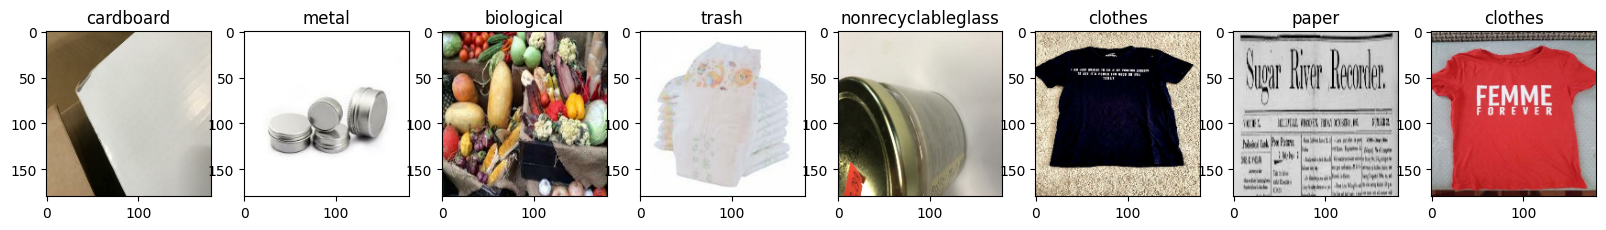

In [ ]:
displayImages(batch)

**Label Distribution:** <br>
Biological - 1<br>
cardboard - 2<br>
clothes - 3<br>
metal - 4<br>
nonrecyclable glass - 5<br>
paper - 6<br>
plastic - 7<br>
recyclable glass - 8<br>
shoes - 9<br>
trash - 10<br>
Battery - 11<br>

---

## Pre-processing
###  > Autotune
This is apparently very useful in making performance better



In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
data = data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

## > Standardization
AKA Rescaling RGB channels from [0,255] to [0,1] for better training

In [ ]:
from tensorflow.keras import layers

In [ ]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
]).

In [ ]:
#Using the rescaling in the plot we made earlier
fig, ax = plt.subplots(ncols=8, figsize=(20,20))
for idx, img in enumerate(batch[0][:8]):
    result = resize_and_rescale(img)
    #below string verifies that the pixels are in the [0,1] range
    print("Min and max pixel values:", result.numpy().min(), result.numpy().max())
    ax[idx].imshow(result)
    select = batch[1][idx]
    ax[idx].title.set_text(class_names[select])

NameError: ignored

### > Split Data

In [ ]:
len(data)

566

In [ ]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [ ]:
print(train_size)
print(val_size)
print(test_size)

396
114
57


In [ ]:
train_data = data.take(train_size)
val_data = data.take(val_size)
test_data = data.take(test_size)

# Start of Training

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
num_classes = len(class_names)

In [ ]:
model = Sequential([
  resize_and_rescale,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile('adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
model.build??

Object `model.build` not found.


In [ ]:
model.build(input_shape=(None, 180, 180, 3))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (180, 180, 3)             0         
                                                                 
 conv2d_3 (Conv2D)           multiple                  448       
                                                                 
 max_pooling2d_3 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           multiple                  4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           multiple                 

In [ ]:
#training the data
epochs=15
history = model.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs
)

Epoch 1/15
396/396 [==============================] - 494s 1s/step - loss: 1.5459 - accuracy: 0.4848 - val_loss: 1.1447 - val_accuracy: 0.6351
Epoch 2/15
396/396 [==============================] - 448s 1s/step - loss: 1.0425 - accuracy: 0.6532 - val_loss: 0.8903 - val_accuracy: 0.7089
Epoch 3/15
396/396 [==============================] - 441s 1s/step - loss: 0.7945 - accuracy: 0.7350 - val_loss: 0.6690 - val_accuracy: 0.7771
Epoch 4/15
396/396 [==============================] - 436s 1s/step - loss: 0.6210 - accuracy: 0.7936 - val_loss: 0.4850 - val_accuracy: 0.8446
Epoch 5/15
396/396 [==============================] - 446s 1s/step - loss: 0.4920 - accuracy: 0.8401 - val_loss: 0.3654 - val_accuracy: 0.8840
Epoch 6/15
396/396 [==============================] - 459s 1s/step - loss: 0.3709 - accuracy: 0.8797 - val_loss: 0.2066 - val_accuracy: 0.9405
Epoch 7/15
396/396 [==============================] - 445s 1s/step - loss: 0.2716 - accuracy: 0.9151 - val_loss: 0.2108 - val_accuracy: 0.9348

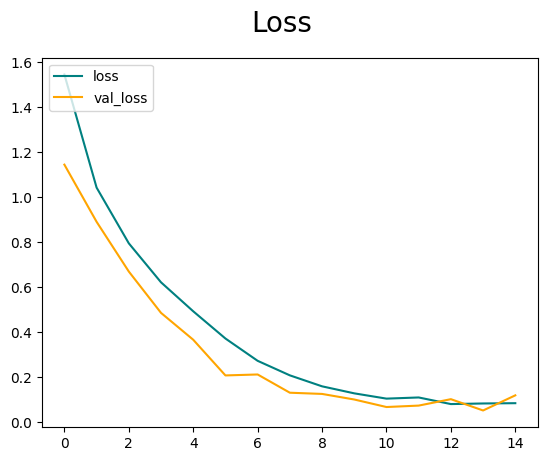

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

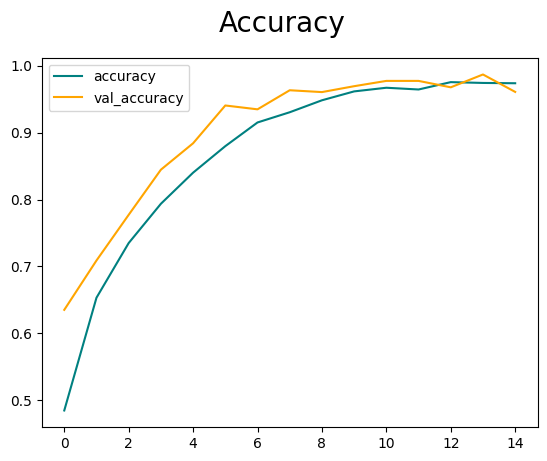

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [4]:
from tensorflow.keras.models import load_model

In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks/data_folder'
%ldir

/content/drive/MyDrive/Colab Notebooks/data_folder
drwx------  2 root   4096 Apr 27 18:41 angry/
drwx------  9 root   4096 Oct 13 22:07 butterfly-dataset/
drwx------  2 root   4096 Apr 27 18:41 fear/
drwx------ 13 root   4096 Oct 11 01:03 garbage_classification/
drwx------  2 root   4096 Apr 27 18:41 happy/
drwx------  2 root   4096 Oct 24 04:25 models/
drwx------  2 root   4096 Apr 27 18:41 sad/


In [ ]:
model.save(os.path.join('models','garbageclassifier1.keras'))

In [ ]:
model.evaluate(test_data)

57/57 [==============================] - 18s 315ms/step - loss: 0.0968 - accuracy: 0.9660


[0.09676894545555115, 0.9660087823867798]

In [7]:
newmodel = load_model(os.path.join('models','garbageclassifier1.keras'))

In [10]:
pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 77.7 MB/s eta 0:00:00


In [11]:
import tensorflowjs as tfjs

In [12]:
#convert to tf.js

tfjs.converters.save_keras_model(newmodel, 'models')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
